# ASSIGNMENT 3
## Sarsa and Q-Learning ALgorithm

DSCI 6650-001: Reinforcement Learning

Student: Sahil Khan

Date: 05-Aug-2025
________________________________________________________________________________

### Step 0: Imports and Helper Functions

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import random
import math
from tqdm.notebook import tqdm

In [15]:
# --- GPU Setup ---
# setting the device directly to CUDA.
device = torch.device("cuda")
print(f"Using GPU: {'Cuda 'if(device.type == 'cuda') else 'CPU'}")

Using GPU: Cuda 


In [16]:
# --- Seeding for reproducibility ---
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Grid World Environment
This class defines the mechanics of our grid world. It knows where the walls and goals are and what happens when the agent tries to move.


In [17]:
# defining the grid world environment
class GridWorld:
    """
    Defining the Grid World environment.
    This is handling state transitions and rewards.
    """
    def __init__(self):
        self.gridHeight = 5
        self.gridWidth = 5
        
        # defining the special states
        self.startState = (4, 0)
        self.terminalStates = [(0, 0), (0, 4)]
        self.redStates = [(2, 0), (2, 1), (2, 3), (2, 4)]
        
        # 0:Up, 1:Down, 2:Left, 3:Right
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.numActions = len(self.actions)

    def getStateInfo(self, state):
        # checking the type of a state
        if tuple(state) in self.terminalStates:
            return "TERMINAL"
        if tuple(state) in self.redStates:
            return "RED"
        return "NORMAL"

    def step(self, state, actionIndex):
        # taking a step in the environment
        if self.getStateInfo(state) == "TERMINAL":
            return state, 0, True

        action = self.actions[actionIndex]
        nextState = (state[0] + action[0], state[1] + action[1])
        
        # checking for out-of-bounds moves
        if not (0 <= nextState[0] < self.gridHeight and 0 <= nextState[1] < self.gridWidth):
            return state, 1, False
            
        # checking the next state to figure out reward
        nextStateType = self.getStateInfo(nextState)
        
        if nextStateType == "RED":
            # hitting a red square sends agent back to start
            reward = -20
            return self.startState, reward, False
        elif nextStateType == "TERMINAL":
            # providing a large positive reward for reaching the goal.
            reward = 50
            return nextState, reward, True
        else: # NORMAL state
            reward = 1
            return nextState, reward, False

In [18]:
# plotting the agent's final path
def plotTrajectory(qTable, grid, title):
    """
    Visualizing the grid and plotting the final path.
    """
    # 0:white, 1:blue(start), 2:black(terminal), 3:red
    cmap = ListedColormap(['white', 'blue', 'black', 'red'])
    gridDisplay = np.zeros((grid.gridHeight, grid.gridWidth))
    
    # marking the special states
    startRow, startCol = grid.startState
    gridDisplay[startRow, startCol] = 1
    for r, c in grid.terminalStates:
        gridDisplay[r, c] = 2
    for r, c in grid.redStates:
        gridDisplay[r, c] = 3

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(gridDisplay, cmap=cmap, interpolation='nearest')

    # figuring out the learned policy by always taking the best action
    currentState = grid.startState
    path = [currentState]
    pathLength = 0
    
    while grid.getStateInfo(currentState) != "TERMINAL" and pathLength < 25:
        # moving Q-values to CPU for plotting with numpy/matplotlib
        qValues = qTable[currentState[0], currentState[1]].cpu()
        bestAction = torch.argmax(qValues).item()
        
        nextState, _, _ = grid.step(currentState, bestAction)
        path.append(nextState)
        currentState = nextState
        pathLength += 1

    # drawing the path on the grid
    pathRows, pathCols = zip(*path)
    ax.plot(np.array(pathCols), np.array(pathRows), 'g-o', linewidth=3, markersize=8, label='Learned Path')

    # formatting the plot
    ax.set_xticks(np.arange(-.5, grid.gridWidth, 1), minor=True)
    ax.set_yticks(np.arange(-.5, grid.gridHeight, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()

In [19]:
# choosing an action with epsilon-greedy
def chooseAction(qTable, state, epsilon, numActions):
    if random.uniform(0, 1) < epsilon:
        # exploring
        return random.randint(0, numActions - 1)
    else:
        # exploiting
        qValues = qTable[state[0], state[1]]
        return torch.argmax(qValues).item()

In [20]:
# main function for running the training process
def runExperiment(algorithmName):
    # setting hyperparameters
    learningRate = 0.1
    discountFactor = 0.99
    numEpisodes = 5000
    maxStepsPerEpisode = 1000  # re-introducing the limit for speed
    
    epsilon = 1.0
    maxEpsilon = 1.0
    minEpsilon = 0.01
    epsilonDecayRate = 0.001

    # setting things up
    env = GridWorld()
    qTable = torch.zeros((env.gridHeight, env.gridWidth, env.numActions), device=device)
    rewardsPerEpisode = []
    
    print(f"\n--- Starting Training for {algorithmName.upper()} ---")
    startTime = time.time()

    # running the main training loop with a progress bar
    pbar = tqdm(range(numEpisodes), desc=f"Training {algorithmName.upper()}", leave=True)
    for episode in pbar:
        state = env.startState
        done = False
        totalEpisodeReward = 0
        steps = 0
        
        if algorithmName == 'sarsa':
            action = chooseAction(qTable, state, epsilon, env.numActions)

        # running each episode with a step limit
        while not done and steps < maxStepsPerEpisode:
            if algorithmName == 'q_learning':
                action = chooseAction(qTable, state, epsilon, env.numActions)

            nextState, reward, done = env.step(state, action)
            totalEpisodeReward += reward
            
            oldQValue = qTable[state[0], state[1], action]

            # applying the main difference between sarsa and q-learning
            if algorithmName == 'sarsa':
                nextAction = chooseAction(qTable, nextState, epsilon, env.numActions)
                nextQValue = qTable[nextState[0], nextState[1], nextAction]
                tdTarget = reward + discountFactor * nextQValue
                
            elif algorithmName == 'q_learning':
                bestNextQValue = torch.max(qTable[nextState[0], nextState[1]])
                tdTarget = reward + discountFactor * bestNextQValue

            # updating the q-value
            newQValue = oldQValue + learningRate * (tdTarget - oldQValue)
            qTable[state[0], state[1], action] = newQValue
            
            state = nextState
            
            if algorithmName == 'sarsa':
                action = nextAction
            
            steps += 1
        
        # decaying epsilon over time
        epsilon = minEpsilon + (maxEpsilon - minEpsilon) * math.exp(-epsilonDecayRate * episode)
        rewardsPerEpisode.append(totalEpisodeReward)
        
        # updating the progress bar description
        if (episode + 1) % 100 == 0:
            avgReward = np.mean(rewardsPerEpisode[-100:])
            pbar.set_postfix({"Avg Reward (last 100)": f"{avgReward:.2f}", "Epsilon": f"{epsilon:.3f}"})
            
    endTime = time.time()
    print(f"--- Training Finished for {algorithmName.upper()} in {endTime - startTime:.2f} seconds ---")
    
    return qTable, rewardsPerEpisode

### --- Running Experiments and Visualizing Results ---

In [21]:
# running both sarsa and q-learning
qTableSarsa, rewardsSarsa = runExperiment('sarsa')


--- Starting Training for SARSA ---


Training SARSA:   0%|          | 0/5000 [00:00<?, ?it/s]

--- Training Finished for SARSA in 1456.37 seconds ---


In [22]:
# running q-learning
qTableQLearning, rewardsQLearning = runExperiment('q_learning')


--- Starting Training for Q_LEARNING ---


Training Q_LEARNING:   0%|          | 0/5000 [00:00<?, ?it/s]

--- Training Finished for Q_LEARNING in 642.55 seconds ---


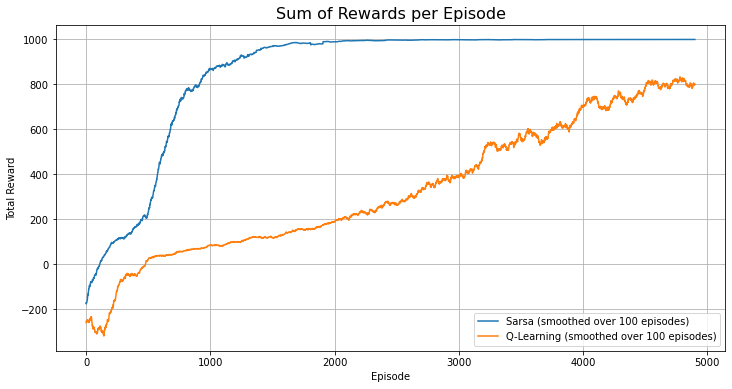

In [23]:
# plotting the rewards to see how they learned
plt.figure(figsize=(12, 6))

# using a moving average to smooth the curve
def movingAverage(data, windowSize):
    return np.convolve(data, np.ones(windowSize)/windowSize, mode='valid')

window = 100
plt.plot(movingAverage(rewardsSarsa, window), label=f'Sarsa (smoothed over {window} episodes)')
plt.plot(movingAverage(rewardsQLearning, window), label=f'Q-Learning (smoothed over {window} episodes)')
plt.title('Sum of Rewards per Episode', fontsize=16)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

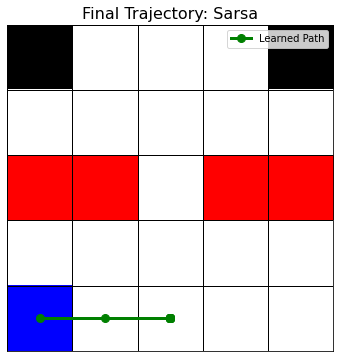

In [24]:
# plotting the final paths they learned
grid = GridWorld()
plotTrajectory(qTableSarsa, grid, title='Final Trajectory: Sarsa')

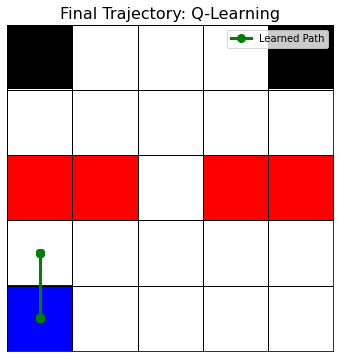

In [25]:
plotTrajectory(qTableQLearning, grid, title='Final Trajectory: Q-Learning')